Importing modules

In [15]:
import numpy as np
import os
from pathlib import Path
from keras.preprocessing import image
from matplotlib import pyplot as plt

In [16]:

labels_dict = {'cat':0,'dog':1,'horse':2,'human':3}
dirs = os.listdir('Images1')
dirs

['cats', 'dogs', 'horses', 'humans']

Creating a features array and labels array for all the images

In [17]:
p = Path('Images1')
dirs = p.glob('*')

labels_dict = {'cat':0,'dog':1,'horse':2,'human':3}

images_data = []
labels = []

for folder_dir in dirs:
    label = str(folder_dir).split('\\')[-1][:-1]
    
    for img_path in folder_dir.glob('*.jpg'):
        img = image.load_img(img_path,target_size = (32,32))
        img_array = image.img_to_array(img)
        images_data.append(img_array)
        labels.append(labels_dict[label])
        

    
    
    
    
    

In [18]:
images_data = np.array(images_data,dtype='float32')/255.0
labels = np.array(labels)

print(images_data.shape)
print(labels.shape)

(808, 32, 32, 3)
(808,)


In [19]:
import random

data = list(zip(images_data,labels))

random.shuffle(data)

images_data[:],labels[:] = zip(*data)

Visualising some random images

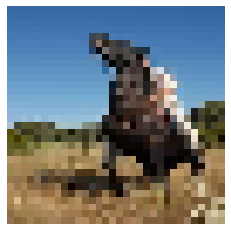

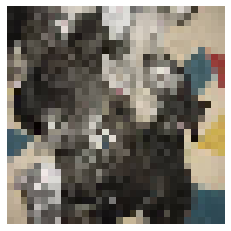

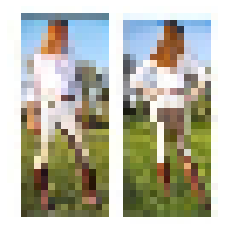

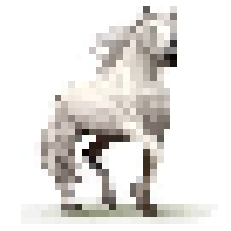

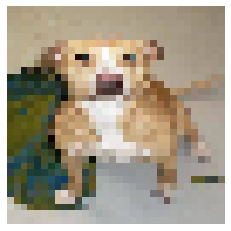

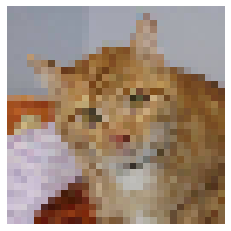

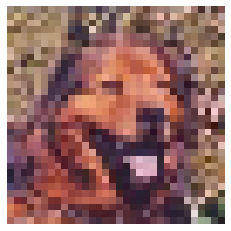

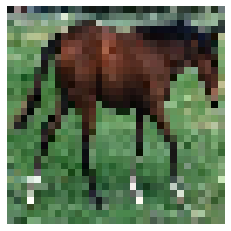

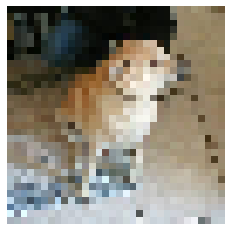

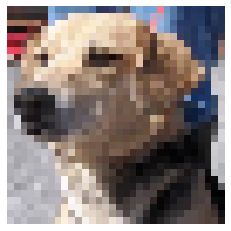

In [20]:

def plotimg(img):
    from matplotlib import pyplot as plt
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    return
    
for i in range(10):
    plotimg(images_data[i])

In [21]:
images_data = images_data.reshape(images_data.shape[0],-1)
images_data.shape

(808, 3072)

SVM classifier

In [22]:
class MySVM():
    def __init__(self,C=1.0):
        self.C = C
        self.W = 0
        self.b = 0
        
    def hingeLoss(self,W,b,X,Y):
        loss  = 0.0
        
        loss += .5*np.dot(W,W.T)
        
        m = X.shape[0]
        
        for i in range(m):
            ti = Y[i]*(np.dot(W,X[i].T)+b)
            loss += self.C *max(0,(1-ti))
            
        return loss[0][0]
    
    def fit(self,X,Y,batch_size=32,learning_rate=0.0001,maxItr=100):
        
        no_of_features = X.shape[1]
        no_of_samples = X.shape[0]
        
        n = learning_rate
        c = self.C
        
        #Init the model parameters
        W = np.zeros((1,no_of_features))
        bias = 0
        losses = []
        
        for i in range(maxItr):
            #Training Loop
            
            l = self.hingeLoss(W,bias,X,Y)
            losses.append(l)
            ids = np.arange(no_of_samples)
            np.random.shuffle(ids)
            
            #Batch Gradient Descent(Paper) with random shuffling
            for batch_start in range(0,no_of_samples,batch_size):
                #Assume 0 gradient for the batch
                gradw = 0
                gradb = 0
                
                #Iterate over all examples in the mini batch
                for j in range(batch_start,batch_start+batch_size):
                    if j<no_of_samples:
                        i = ids[j]
                        ti =  Y[i]*(np.dot(W,X[i].T)+bias)
                        
                        if ti>1:
                            gradw += 0
                            gradb += 0
                        else:
                            gradw += c*Y[i]*X[i]
                            gradb += c*Y[i]
                            
                #Gradient for the batch is ready! Update W,B
                W = W - n*W + n*gradw
                bias = bias + n*gradb
                
        
        self.W = W
        self.b = bias
        return W,bias,losses
                
                             

In [23]:
classes = np.unique(labels)
classes

array([0, 1, 2, 3])

In [24]:
def class_wisedata(x,y):
    data = {}
    for i in range(len(classes)):
        data[i] = []
        
    for i in range(x.shape[0]):
        data[y[i]].append(x[i])
        
    for k in data.keys():
        data[k] = np.array(data[k])
        
    return data

In [25]:
data = class_wisedata(images_data,labels)

print(data[0].shape)
print(data[1].shape)
print(data[2].shape)
print(data[3].shape)

(202, 3072)
(202, 3072)
(202, 3072)
(202, 3072)


For one vs one claasification if we have n classes then we require nc2 classifiers.
So in our case we have 4 classes therefore we need 6 classifiers.

In [26]:
#Function for getting data for two classes at a time.

def pair_data(d1,d2):
    l1 = d1.shape[0]
    l2 = d2.shape[0]
    samples = l1+l2
    features = d1.shape[1]
    
    data_pair = np.zeros((samples,features))
    data_labels = np.zeros((samples))
    
    data_pair[:l1,:] = d1
    data_pair[l1:,:] = d2
    
    data_labels[:l1] = -1
    data_labels[l1:] = 1
    
    return data_pair,data_labels

# Training nc2 SVM classifiers

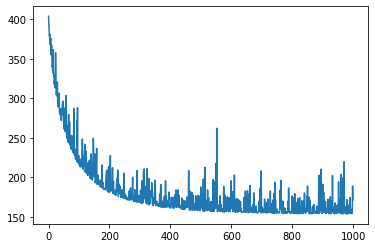

In [27]:
svm = MySVM()
xp, yp = pair_data(data[0], data[1])
w,b,loss = svm.fit(xp,yp,learning_rate=0.0001,maxItr=1000)
plt.plot(loss)


In [28]:
def train_svms(X,Y):
    svm_classifiers = {}
    for i in range(len(classes)):
        svm_classifiers[i] = {}
        for j in range(i+1,len(classes)):
            svm = MySVM()
            x,y = pair_data(data[i],data[j])
            w,b,loss = svm.fit(x,y,learning_rate=0.00001,maxItr=1000)
            svm_classifiers[i][j] = (w,b)
            plt.plot(loss)
            plt.show()
    return svm_classifiers

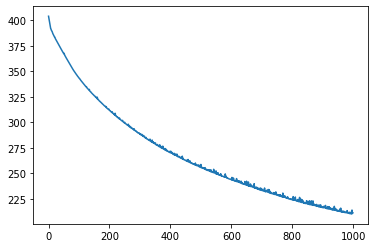

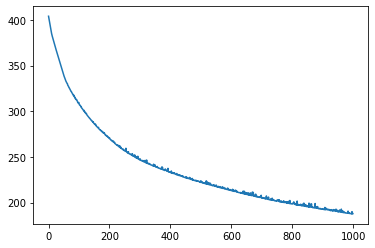

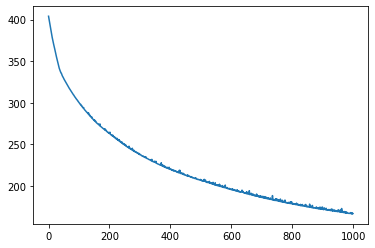

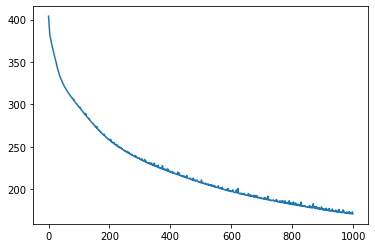

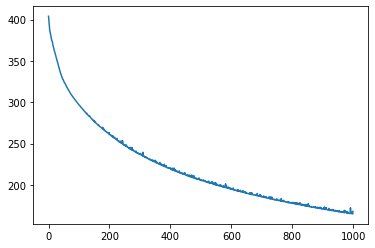

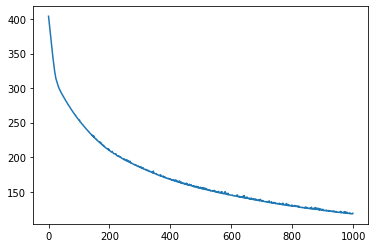

{0: {1: (array([[0.01680039, 0.01100187, 0.01250098, ..., 0.0064293 , 0.00379726,
           0.00278515]]),
   0.051129999999999926),
  2: (array([[-0.01533587, -0.01566215, -0.00761039, ...,  0.02482428,
            0.02025689, -0.01519596]]),
   -0.05889999999999999),
  3: (array([[0.03110906, 0.02771857, 0.02959085, ..., 0.02485848, 0.02854226,
           0.02343557]]),
   -0.0047999999999999935)},
 1: {2: (array([[-0.02652849, -0.01728948, -0.00763046, ...,  0.01019251,
            0.01465795, -0.008819  ]]),
   -0.10635000000000018),
  3: (array([[0.00666611, 0.00777126, 0.01076297, ..., 0.01747041, 0.02770309,
           0.02266769]]),
   -0.037500000000000186)},
 2: {3: (array([[0.0344283 , 0.02637784, 0.02456059, ..., 0.01088099, 0.01992454,
           0.0384781 ]]),
   0.07740000000000051)},
 3: {}}

In [29]:
svm_classifiers = train_svms(images_data,labels)
svm_classifiers

In [30]:
def binaryPredict(X,w,b):
    z = np.dot(X,w.T)+b
    if z>=0:
        return 1
    else:
        return -1
    

Creating a predict function for making predictions

In [31]:
def predict(X):
    counts = np.zeros((len(classes)))
    for i in range(len(classes)):
        for j in range(i+1,len(classes)):
            w,b = svm_classifiers[i][j]
            
            z = binaryPredict(X,w,b)
            if z==-1:
                counts[i]+=1
            else:
                counts[j]+=1
        
    final_prediction = np.argmax(counts)
    
    return final_prediction
                

In [32]:
r = predict(images_data[4])
r

0

In [33]:
labels[4]

1

Defining an accuracy function

In [34]:
def accuracy(x,y):
    
    pred = []
    count=0
    
    for i in range(x.shape[0]):
        prediction = predict(x[i])
        pred.append(prediction)
        if prediction==y[i]:
            count += 1
    
    return count/x.shape[0], pred

In [35]:
acc, ypred = accuracy(images_data, labels)

print(acc)

0.6101485148514851
